# Recovering jobs

This document shows you how to recover a `POVMSamplerJob` object after closing your Python session. This is mostly useful when working with jobs submitted via the `QiskitRuntimeService`.

## Use cases

### Using the QiskitRuntimeService


When running jobs using real hardware, they may queue for a long time.
During this time, you may purposefully (or accidentally) close your Python session. The `POVMSamplerJob.recover_job()` method is provided to deal with that issue and this notebook explains how to use it.

If you close your Python session, you can obtain your job's results using the QiskitRuntimeService. However, this is only the `BasePrimitiveJob` that gets submitted internally within the `POVMSampler`. The actual job object which you need for the `POVMPostProcessor` is a `POVMSamplerJob` which also contains the appropriate POVM metadata.

For this reason, you should first save the appropriate POVM metadata before closing any session. You can then recover the full `POVMSamplerJob` object at a later time.



### Using a local simulator or another service 

When not using the `QiskitRuntimeService`, you are likely running your job in a local simulator. In this case the results would not be available if your Python session were closed. As a result, saving POVM metadata will not allow you to recover the job after closing the session.

Still, we also allow the user to inject a custom `BasePrimitiveJob` object into the recovery method (e.g. if there was some other service which could recover jobs based on their IDs). However, this is not the main intended usecase of the recovery method, which is mainly designed to work with the `QiskitRuntimeService`.


## Tutorial

### Define circuit and measurement

Define quantum circuit

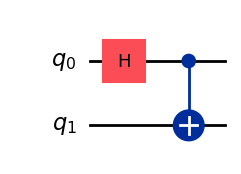

In [2]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw("mpl", style="iqp")

Transpile circuit

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()
backend.set_options(seed_simulator=25)
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

# Transpile the circuit to an "Instruction Set Architecture" (ISA) circuit.
# Note: the transpiler automatically adds "ancilla" qubits to make the transpiled
# circuit match the size of the FakeSherbrooke backend.
qc_isa = pm.run(qc)

Define measurement procedure

In [4]:
from povm_toolbox.library import ClassicalShadows

measurement = ClassicalShadows(2, seed=13)

### Submit the job

Initialize `Sampler` and `POVMSampler`. Then run the job.

In [5]:
from povm_toolbox.sampler import POVMSampler
from qiskit_ibm_runtime import SamplerV2 as RuntimeSampler

# First define a standard sampler (that will be used under the hood).
runtime_sampler = RuntimeSampler(backend=backend)
# Then define the POVM sampler, which takes BaseSampler as an argument.
povm_sampler = POVMSampler(runtime_sampler)
# Submit the job by specifying which POVM to use, which circuit(s) to measure and the shot budget.
job = povm_sampler.run(pubs=[qc_isa], shots=128, povm=measurement)

### Save the metadata

In [6]:
job.save_metadata(filename="saved_metadata.pkl")

Job metadata successfully saved in the 'saved_metadata.pkl' file.


Save the internal `BasePrimitiveJob` somewhere. If you are using `QiskitRuntimeService`, it is automatically saved in its servers.

In this tutorial we just save it in a temporary variable:

In [7]:
tmp = job.base_job

### Recover job

The recovery of a `POVMSamplerJob` can be achieved through the `POVMSamplerJob.recover_job` method. 

When not using QiskitRuntimeService, job recovery necessitates the user to provide the internal `BasePrimitiveJob` object and the name of the file where the POVM-related metadata is stored:

In [8]:
from povm_toolbox.sampler import POVMSamplerJob

job_recovered = POVMSamplerJob.recover_job(filename="saved_metadata.pkl", base_job=tmp)

> **Note**: 
>
> If you are using QiskitRuntimeService, you don't have to directly provide the internal `BasePrimitiveJob`. The `POVMSamplerJob.recover_job` method uses by default the QiskitRuntimeService functionalities to recover the job from its ID:
> ```python
>   service = QiskitRuntimeService()
>   base_job = service.job(job_id)
> ```
> 
> 
> As the job ID is stored in the metadata file, one can simply execute
> ```python
>   job_recovered = POVMSamplerJob.recover_job(filename="saved_metadata.pkl")
> ```
> when using QiskitRuntimeService.

You can then work with the recovered job

In [9]:
from povm_toolbox.post_processor import POVMPostProcessor

result = job_recovered.result()
pub_result = result[0]
post_processor = POVMPostProcessor(pub_result)

In [10]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

exp_value = post_processor.get_expectation_value(observable)
print(exp_value)

3.53125


In [ ]:
from pathlib import Path

# delete the metadata file
Path("saved_metadata.pkl").unlink(missing_ok=True)